In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
#
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
sns.set()
#
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from prince import FAMD
#
import warnings
warnings.filterwarnings('ignore')

In [162]:
from prince import FAMD

### categorical variable
Sex
- 0: male 
- 1: female

marital status
- 0: single
- 1: non-single(divorced/separated/married/widowed)

Education
- 0: other/unknown 
- 1: high school 
- 2: university 
- 3: graduate school

occupation
- 0: unemployed/unskilled 
- 1: skilled employee/official
- 2: management / self-employed / highly qualified employee / officer

settlement size
- 0: small city 
- 1: mid-sized city
- 2: big city

In [3]:
df=pd.read_csv('C:/Users/USER/Desktop/abtest/segmentation/segmentation data.csv',index_col=0)

In [4]:
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sex,2000.0,0.4570,0.498272,0.0,0.00,0.0,1.00,1.0
Marital status,2000.0,0.4965,0.500113,0.0,0.00,0.0,1.00,1.0
Age,2000.0,35.9090,11.719402,18.0,27.00,33.0,42.00,76.0
Education,2000.0,1.0380,0.599780,0.0,1.00,1.0,1.00,3.0
Income,2000.0,120954.4190,38108.824679,35832.0,97663.25,115548.5,138072.25,309364.0
Occupation,2000.0,0.8105,0.638587,0.0,0.00,1.0,1.00,2.0
Settlement size,2000.0,0.7390,0.812533,0.0,0.00,1.0,1.00,2.0


- Income의 scale이 눈에 띄게 큰 것을 확인할 수 있다.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 100000001 to 100002000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 125.0 KB


- dataframe에 결측치 없는 것 확인.

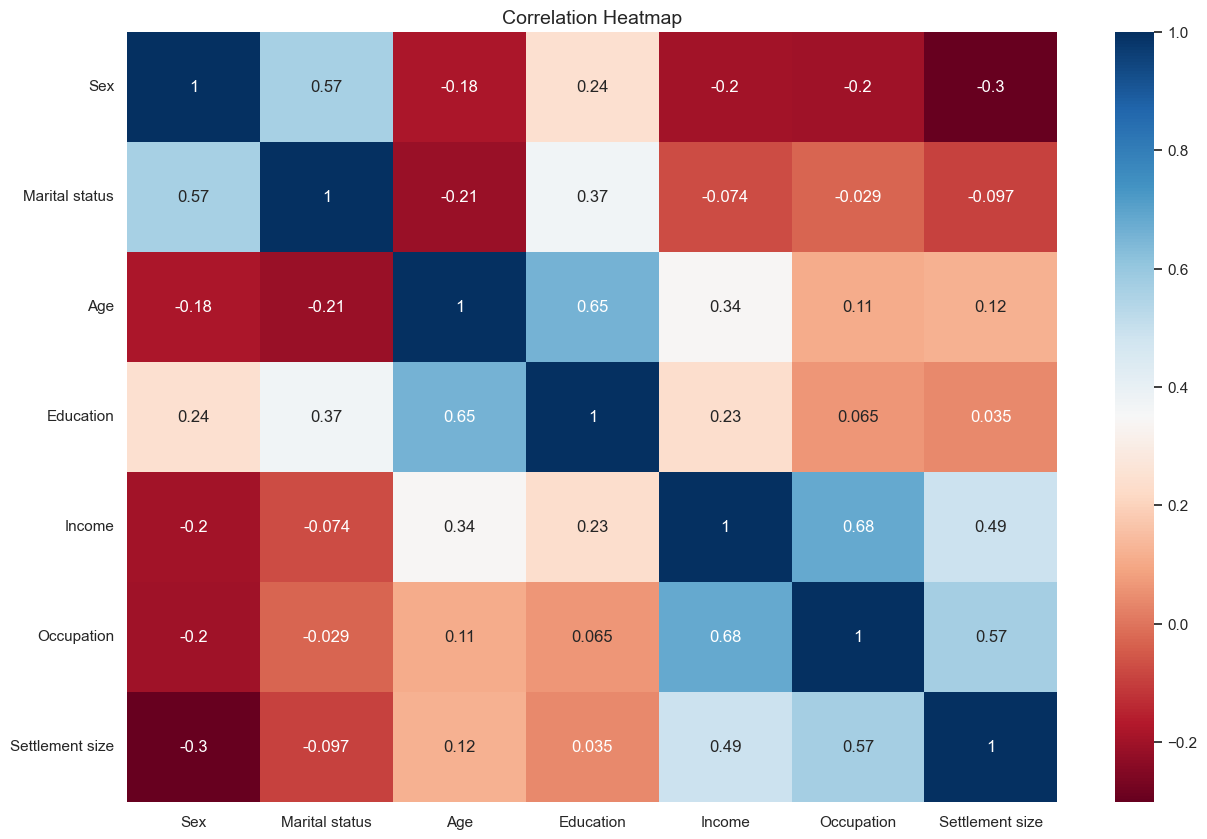

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True,cmap='RdBu')
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0)
plt.show()

- Age와 Education, Income과 Occupation간에 상관관계가 있는 것으로 판단 된다.

- Education은 categorical variable인 동시에 ordinal variable이므로 Age와 상관관계가 높은 것을 직관적으로 이해할 수 있다.

- Occupation도 마찬가지로 categorical variable인 동시에 ordinal variable이므로 직업의 전문성이 높을수록, 소득도 높은 것을 직관적으로 이해할 수 있다.

Text(0.5, 1.0, 'Visualization of raw data')

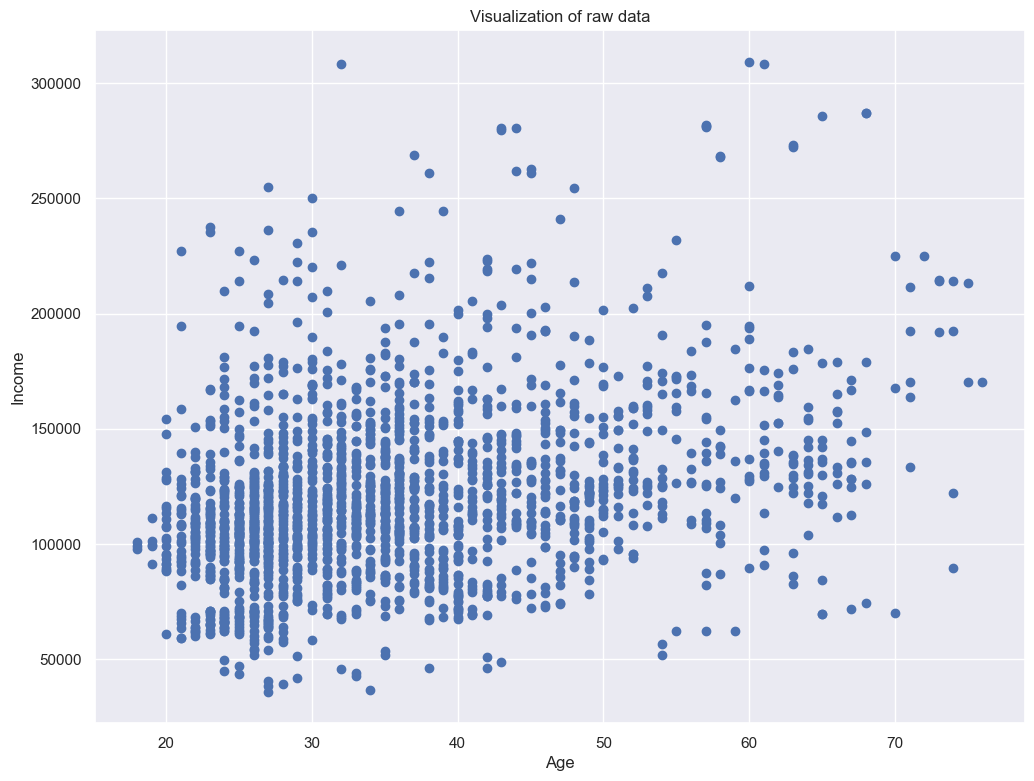

In [13]:
plt.figure(figsize = (12, 9))
plt.scatter(df.iloc[:, 2], df.iloc[:, 4])
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Visualization of raw data')

## Data Scaling

- scaling numerical variables, excluding Sex, Marital status, Occupation since they are categorical variables : 원본 포스팅에서는 categorical variable까지 scaling을 했지만, 이것은 틀린 개념이기에 본 실습에서는 numerical variable과 categorical variable이지만 ordinal한 variable만 scaling함.

- $z=\frac{x-\mu}{\sigma}$


In [8]:
df_sorted=df.drop(columns=['Sex','Marital status','Occupation'])
scaler = StandardScaler()
df_std = scaler.fit_transform(df_sorted)
df_std=pd.DataFrame(df_std,columns=df_sorted.columns)

for col in ['Sex','Marital status','Occupation']:
    df_std[col]=df[col].tolist()
    
df_std=df_std[df.columns.tolist()]

In [9]:
df_std.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,2.653614,1.604323,0.097524,1,1.552326
1,1,1,-1.187132,-0.063372,0.782654,1,1.552326
2,0,0,1.117316,-0.063372,-0.833202,0,-0.909730
3,0,0,0.775916,-0.063372,1.328386,1,0.321298
4,0,0,1.458716,-0.063372,0.736932,1,0.321298


### K-means clustering

In [12]:
wcss = []
for i in range(1,21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 38)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)

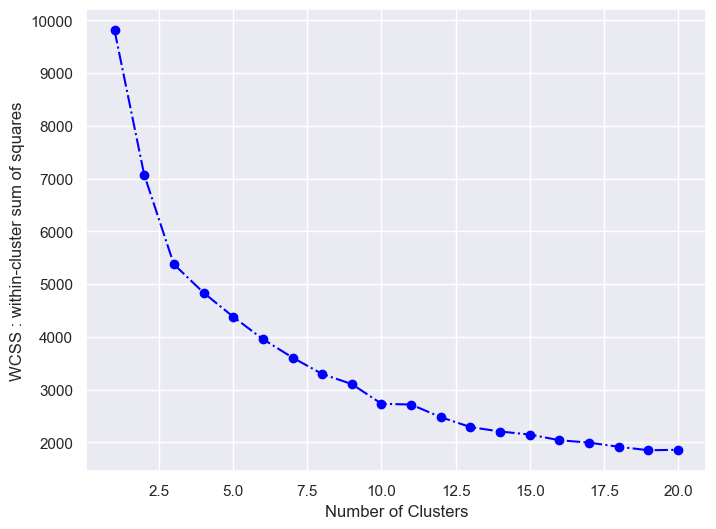

In [13]:
# Plot the Within Cluster Sum of Squares for the different number of clusters.
plt.figure(figsize = (8,6))
plt.plot(range(1, 21), wcss, marker = 'o', linestyle = '-.',color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS : within-cluster sum of squares')
plt.show()

- elbow method에 의해 적절한 cluster number는 4로 판단.

In [14]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 38)
kmeans.fit(df_std)

KMeans(n_clusters=4, random_state=38)

In [26]:
df_seg= df.copy()
df_seg['Segment K-means'] = kmeans.labels_

In [22]:
df_seg.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means
ID,,,,,,,,
100000001,0,0,67,2,124670,1,2,2
100000002,1,1,22,1,150773,1,2,3
100000003,0,0,49,1,89210,0,0,1
100000004,0,0,45,1,171565,1,1,3
100000005,0,0,53,1,149031,1,1,2


- 원본 dataframe에 K-Means 클러스터링 결과를 segment K-means 컬럼으로 추가함.

In [27]:
df_seg.groupby('Segment K-means').mean()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.648936,0.664894,53.968085,2.053191,118116.335106,0.452128,0.292553
1,0.590261,0.513064,31.148456,0.839667,97381.321853,0.406176,0.010689
2,0.303318,0.492891,52.545024,1.777251,181752.625592,1.469194,1.568720
3,0.304348,0.437418,32.092227,0.801054,130906.574440,1.164690,1.426877


- (0,2) cluster, (1,3) cluster는 Age,Education이 비슷한 수준이지만 Income,occupation,settlement size에서 큰 차이를 보임.

- 0 ,2 cluster는 고령이고, 학력 수준도 제일 높지만 0 cluster는 2 cluster에 비해 상대적으로 임금도 낮고, unskillful하며, small city에 거주하는 집단. male의 비율이 높음.

- 마찬가지로 1 cluster가 3 cluster에 비해 상대적으로 임금도 낮고, unskillful하며, small city에 거주한다고 볼 수 있음.  male의 비율이 높음.

- 따라서 (0,2) cluster를 각각 'old_small_city' , 'old_big_city', (1,3) cluster를 각각 'young_small_city' , 'young_big_city' 라 지칭함.

In [28]:
df_seg['Labels'] = df_seg['Segment K-means'].map({
    0:'old_small_city',1:'young_small_city',2:'old_big_city',3:'young_big_city'})

In [164]:
df_seg.groupby('Labels').mean()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means
Labels,,,,,,,,
old_big_city,0.303318,0.492891,52.545024,1.777251,181752.625592,1.469194,1.568720,2.0
old_small_city,0.648936,0.664894,53.968085,2.053191,118116.335106,0.452128,0.292553,0.0
young_big_city,0.304348,0.437418,32.092227,0.801054,130906.574440,1.164690,1.426877,3.0
young_small_city,0.590261,0.513064,31.148456,0.839667,97381.321853,0.406176,0.010689,1.0


In [29]:
df_seg.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means,Labels
ID,,,,,,,,,
100000001,0,0,67,2,124670,1,2,2,old_big_city
100000002,1,1,22,1,150773,1,2,3,young_big_city
100000003,0,0,49,1,89210,0,0,1,young_small_city
100000004,0,0,45,1,171565,1,1,3,young_big_city
100000005,0,0,53,1,149031,1,1,2,old_big_city


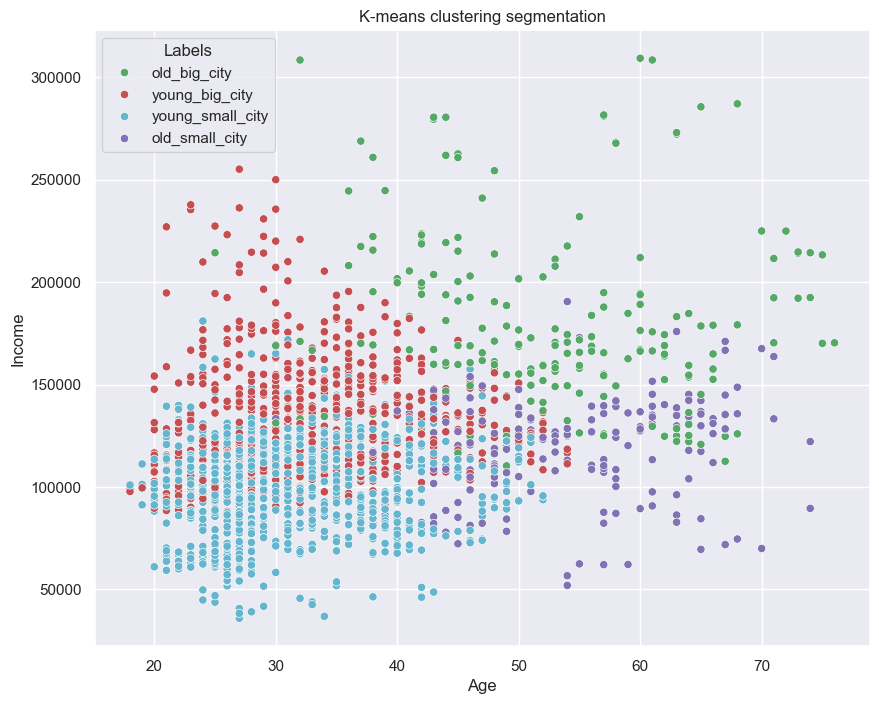

In [167]:
# We plot the results from the K-means algorithm. 
# Each point in our data set is plotted with the color of the clusters it has been assigned to.
x_axis = df_seg['Age']
y_axis = df_seg['Income']
plt.figure(figsize = (10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_seg['Labels'], palette = ['g', 'r', 'c', 'm'])
plt.title('K-means clustering segmentation')
plt.show()

- young vs old, small city vs old city의 구분은 비교적 뚜렷하다.

- young big city vs young small city의 구분은 뚜렷하지 않다.

#### pca(principle component analysis)
- pca를 적용해 변수의 정보를 압축함으로써 고차원의 데이터로 K-means clustering을 적용.
- pca는 numerical variable에 적합한 방법론이라 categorical variable에 적용하면 정보 왜곡이 발생할 수 있음.

In [36]:
scaler = StandardScaler()
df_all_std = scaler.fit_transform(df_std)
pca = PCA()
pca.fit(df_all_std)

PCA()

- categorical variable에 pca를 적용하기 위해 scaling 한 후, pca 적용

Text(0, 0.5, 'Cumulative Explained Variance')

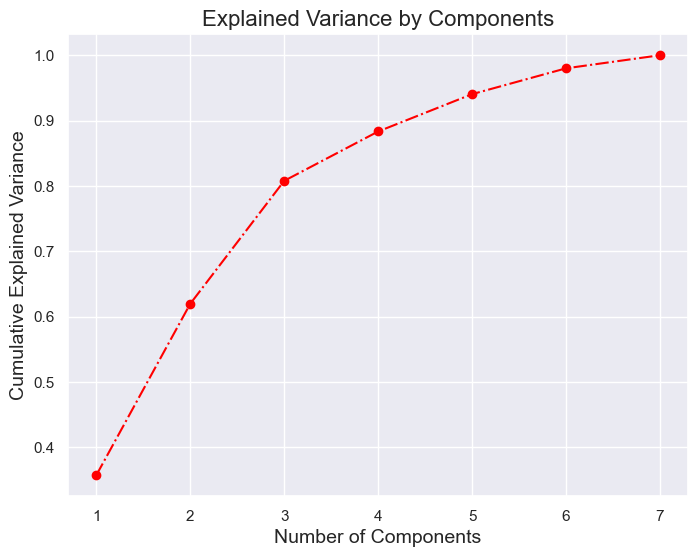

In [37]:
plt.figure(figsize = (8,6))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '-.',color='red')
plt.title('Explained Variance by Components',fontsize=16)
plt.xlabel('Number of Components',fontsize=14)
plt.ylabel('Cumulative Explained Variance',fontsize=14)
## 3개까지만 쓰자

- 주성분을 3개까지 사용하면 데이터 변동의 80% 이상을 설명 가능.

In [38]:
pca = PCA(n_components = 3)
pca.fit(df_all_std)
df_all_std=pd.DataFrame(df_all_std,columns=df_std.columns)

PCA(n_components=3)

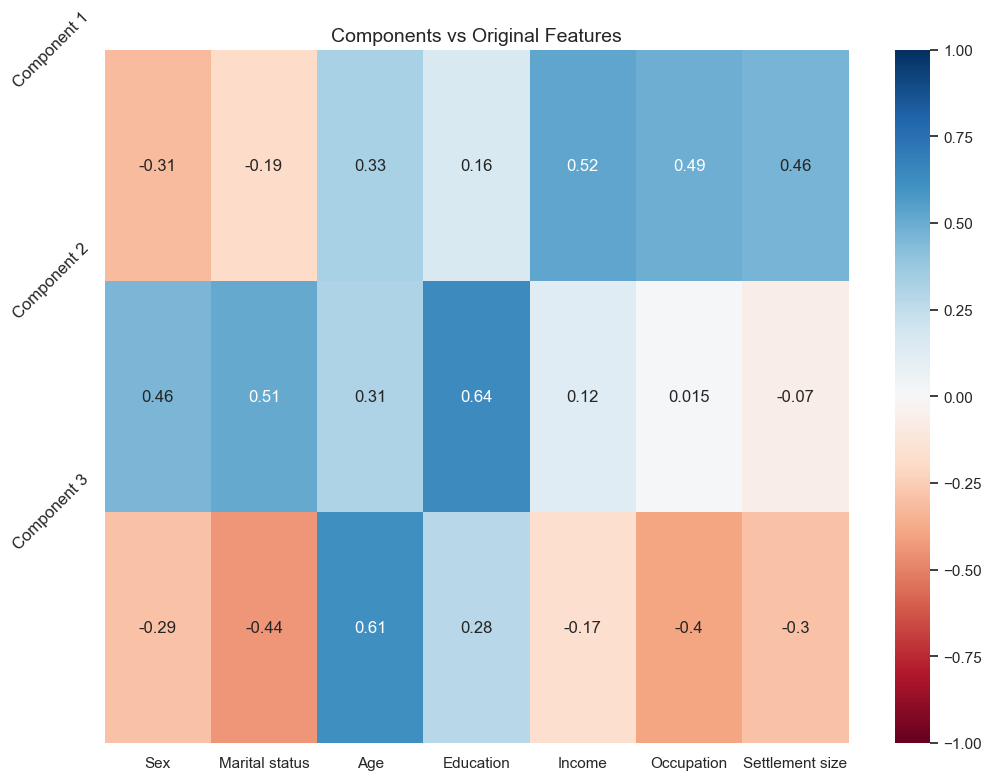

In [41]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df_std.columns,
                           index = ['Component 1', 'Component 2', 'Component 3'])
# Heat Map for Principal Components 
plt.figure(figsize=(12,9))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

- principle component는 각 original variable을 가중합한 형태.

- Component1은 데이터를 주로 income,occupation,settlement size의 관점에서,

- Component2는 Sex,Marital status,Education의 관점에서,

- Conponent3는 Age의 관점에서 데이터의 변동을 설명한다고 볼 수 있음.

- 각 주성분은 서로 직교하고 독립적이므로, 원래 변수들이 담고 있는 정보를 중복 없이 분해하여 각각의 주성분에서 설명해야 하는데, 각 주성분의 loading 값을 가지는 변수는 중복되지 않는 것으로 보아, 데이터의 정보가 적절히 분해된 것으로 보임.

In [48]:
scores_pca = pca.transform(df_all_std)
scores_pca

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

### K-means clustering with pca

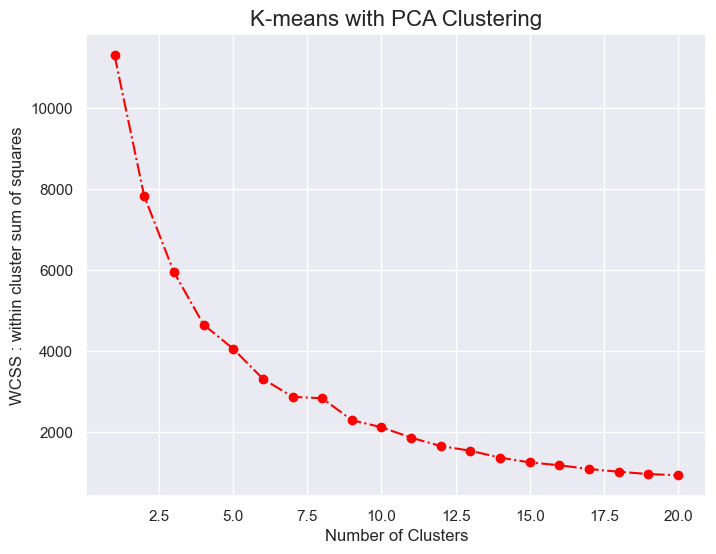

In [163]:
# We fit K means using the transformed data from the PCA.
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 38)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

# Plot the Within Cluster Sum of Squares for the K-means PCA model. Here we make a decission about the number of clusters.
# Again it looks like four is the best option.
plt.figure(figsize = (8,6))
plt.plot(range(1, 21), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS : within cluster sum of squares')
plt.title('K-means with PCA Clustering',fontsize = 16)
#plt.savefig('kmpcac.png')
plt.show()

- pca이후 K-means clustering한 wcss plot. elbow method에 의해 cluster number로 8을 택함.

In [51]:
kmeans_pca = KMeans(n_clusters = 8, init = 'k-means++', random_state = 38)
kmeans_pca.fit(scores_pca)

KMeans(random_state=38)

In [58]:
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [59]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.
df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
# The last column we add contains the pca k-means clustering labels.
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [68]:
# pca 적용하지 않은 k-means clustering 결과.
df_seg.groupby('Labels').mean()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means
Labels,,,,,,,,
old_big_city,0.303318,0.492891,52.545024,1.777251,181752.625592,1.469194,1.568720,2.0
old_small_city,0.648936,0.664894,53.968085,2.053191,118116.335106,0.452128,0.292553,0.0
young_big_city,0.304348,0.437418,32.092227,0.801054,130906.574440,1.164690,1.426877,3.0
young_small_city,0.590261,0.513064,31.148456,0.839667,97381.321853,0.406176,0.010689,1.0


In [69]:
# pca 적용한 k-means clustering 결과.
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.774194,0.750000,53.008065,2.120968,108981.991935,0.201613,0.080645,-0.549210,2.165986,1.645568
1,0.020339,0.020339,41.816949,1.000000,130391.684746,0.969492,1.101695,1.072904,-0.769352,0.696104
2,0.078512,0.400826,32.979339,0.809917,158446.743802,1.652893,1.677686,1.837103,-0.705939,-0.976608
3,0.890282,0.968652,27.637931,1.000000,107752.978056,0.711599,0.462382,-1.111141,0.599756,-0.900635
4,0.000000,0.066667,63.480000,1.973333,171301.413333,1.293333,1.293333,2.847978,1.000139,1.793234
5,0.456522,0.152174,36.318841,0.916667,89112.050725,0.101449,0.018116,-1.285347,-0.530711,1.110323
6,0.681818,1.000000,49.886364,2.143939,168533.871212,1.371212,1.424242,1.822498,2.385276,-0.145509
7,0.041284,0.000000,27.178899,0.000000,106192.701835,0.688073,0.697248,-0.382973,-2.278996,-0.092622


- pca를 적용한 clustering 결과와 적용하지 않은 clustering 결과를 보여준다. 

- cluster 수가 8개라 눈에 띄는 구별점을 평균 수치만으로는 파악하기 어려움.

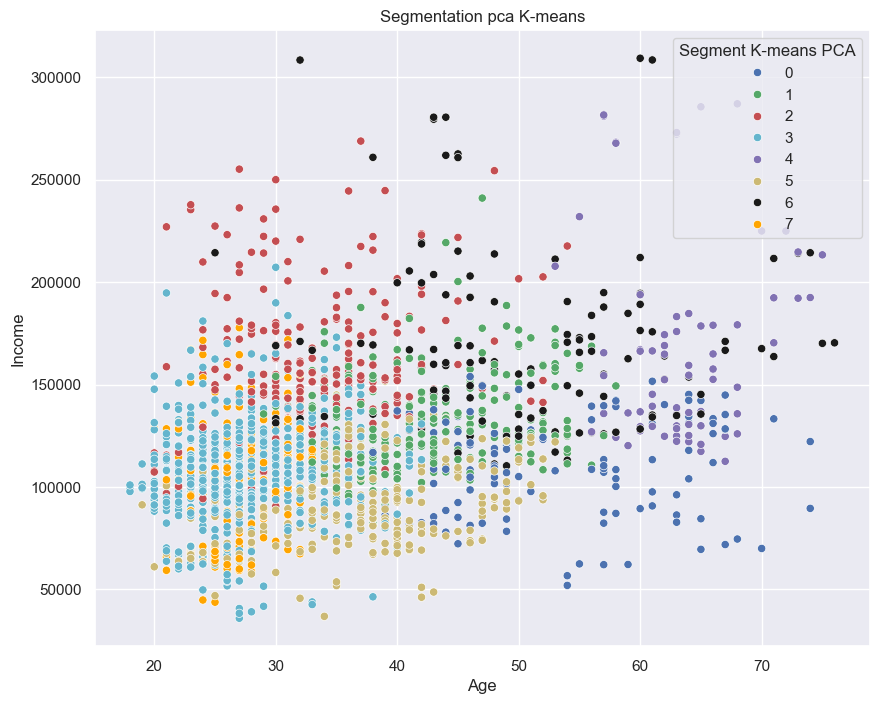

In [130]:
# We plot the results from the K-means algorithm. 
# Each point in our data set is plotted with the color of the clusters it has been assigned to.
x_axis = df_segm_pca_kmeans['Age']
y_axis = df_segm_pca_kmeans['Income']
plt.figure(figsize = (10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Segment K-means PCA'], palette = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500'])
plt.title('Segmentation pca K-means')
plt.show()

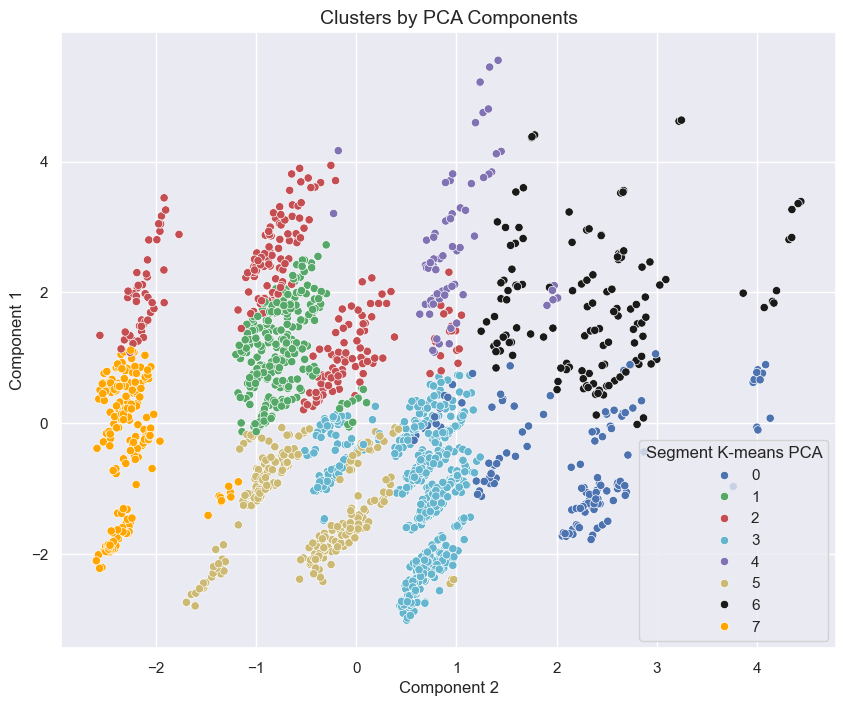

In [73]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Segment K-means PCA'], palette = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500'])#, palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components',fontsize=14)
#plt.savefig('scaling_numeric_only.png')
plt.show()

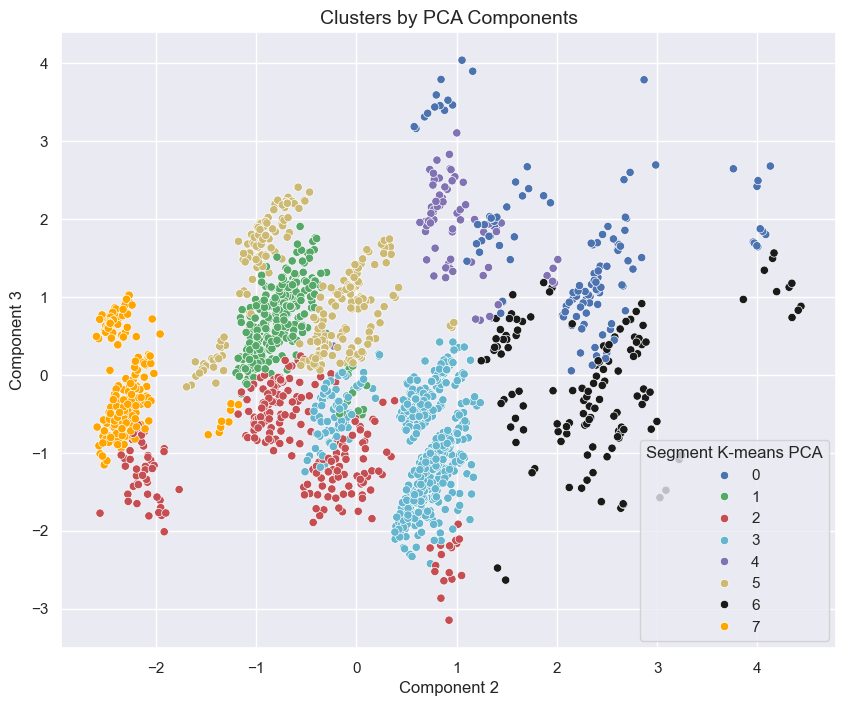

In [74]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 3']
plt.figure(figsize = (10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Segment K-means PCA'], palette = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500'])#, palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components',fontsize=14)
#plt.savefig('scaling_numeric_only.png')
plt.show()

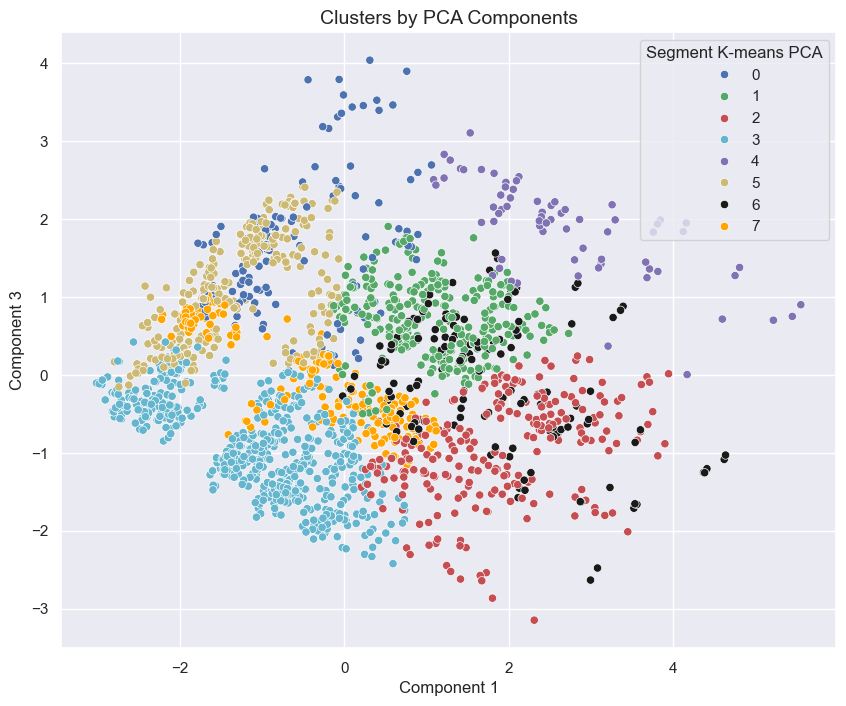

In [75]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 1']
y_axis = df_segm_pca_kmeans['Component 3']
plt.figure(figsize = (10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Segment K-means PCA'], palette = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500'])#, palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components',fontsize=14)
#plt.savefig('scaling_numeric_only.png')
plt.show()

- cluster 수가 4개에서 8개로 늘어나 해석이 어려워진 것에 비해, cluster간의 구분이 더 뚜렷해지진 않았다.

- 이는 categorical variable에 pca를 적용해서 정보 왜곡이 일어난 것으로 보고, categorical ,numerical variable이 혼재되어 있는 데이터에 적합한 FAMD(Factor Analysis of Mixed Data)를 적용해 보기로 한다.

In [76]:
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [87]:
df_famd=df.copy()
df_famd['Sex']=df['Sex'].map({0:'male',1:'female'})
df_famd['Marital status']=df['Marital status'].map({0:'single',1:'non-single'})
df_famd['Education']=df['Education'].map({0:'other/unknown',1:'high school',2:'university',3:'graduate school'})
df_famd['Occupation']=df['Occupation'].map({0:'unemployed/unskilled',1:'skilled employee',2:'highly qualified employee'})
df_famd['Settlement size']=df['Settlement size'].map({0:'small city',1:'mid-sized city',2:'big city'})
df_famd['Age'] = df_famd['Age'].astype(float)
df_famd['Income'] = df_famd['Income'].astype(float)
df_famd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 100000001 to 100002000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex              2000 non-null   object 
 1   Marital status   2000 non-null   object 
 2   Age              2000 non-null   float64
 3   Education        2000 non-null   object 
 4   Income           2000 non-null   float64
 5   Occupation       2000 non-null   object 
 6   Settlement size  2000 non-null   object 
dtypes: float64(2), object(5)
memory usage: 125.0+ KB


In [88]:
famd=FAMD(n_components=10,random_state=38).fit(df_famd)

In [90]:
famd

FAMD(n_components=10, random_state=38)

In [95]:
print(famd.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              5.394        22.02%                     22.02%
1              4.239        17.30%                     39.32%
2              3.206        13.09%                     52.40%
3              2.657        10.84%                     63.25%
4              2.413         9.85%                     73.09%
5              2.192         8.95%                     82.04%
6              1.861         7.60%                     89.64%
7              1.061         4.33%                     93.97%
8              0.915         3.73%                     97.70%
9              0.371         1.51%                     99.22%


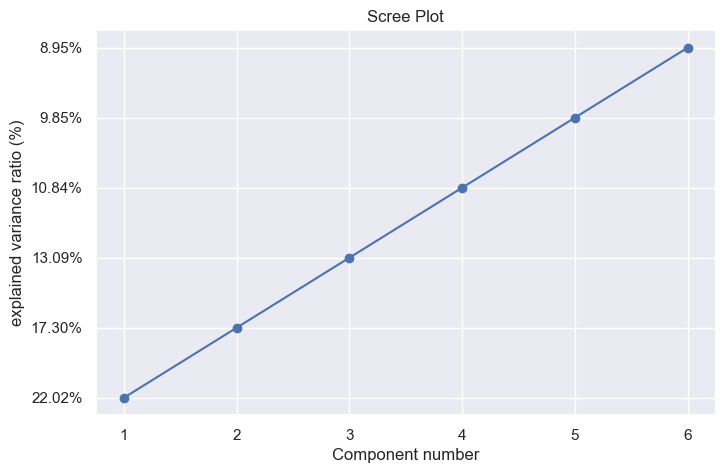

In [106]:
explained_variance = famd.eigenvalues_summary['% of variance']
# Scree Plot 그리기
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Component number')
plt.ylabel('explained variance ratio (%)')
plt.title('Scree Plot')
plt.grid(True)
plt.savefig('screeplot.png')
plt.show()

- 성분 6개 사용하기로 결정

In [101]:
famd=FAMD(n_components=6,random_state=38).fit(df_famd)

In [131]:
famd.fit(df_famd)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,male,single,67.0,university,124670.0,skilled employee,big city
100000002,female,non-single,22.0,high school,150773.0,skilled employee,big city
100000003,male,single,49.0,high school,89210.0,unemployed/unskilled,small city
100000004,male,single,45.0,high school,171565.0,skilled employee,mid-sized city
100000005,male,single,53.0,high school,149031.0,skilled employee,mid-sized city
...,...,...,...,...,...,...,...
100001996,female,single,47.0,high school,123525.0,unemployed/unskilled,small city
100001997,female,non-single,27.0,high school,117744.0,skilled employee,small city
100001998,male,single,31.0,other/unknown,86400.0,unemployed/unskilled,small city


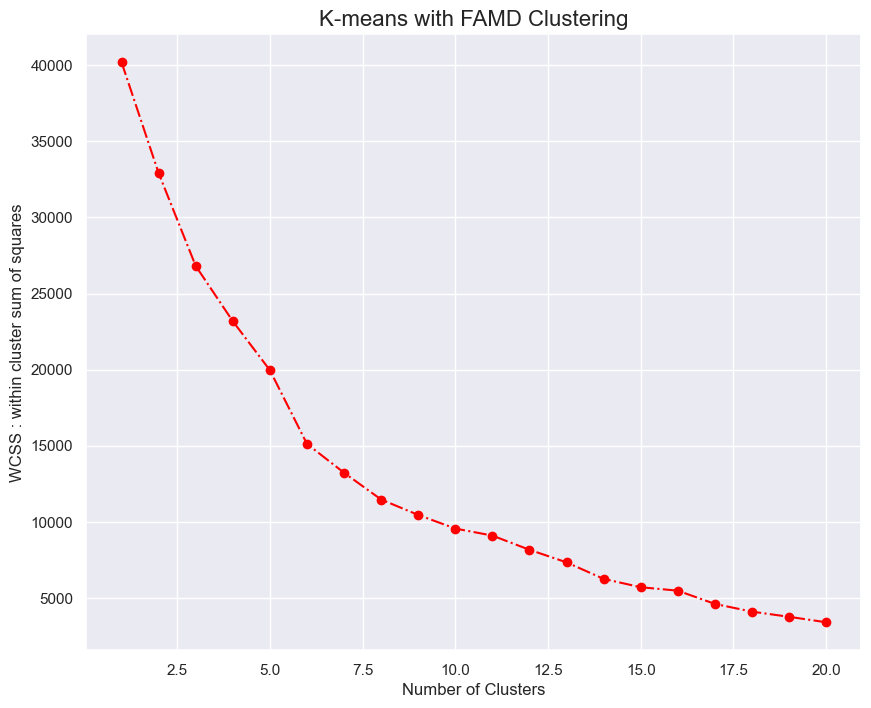

In [135]:
# We fit K means using the transformed data from the PCA.
wcss = []
for i in range(1,21):
    kmeans_famd = KMeans(n_clusters = i, init = 'k-means++', random_state = 38)
    kmeans_famd.fit(famd.row_coordinates(df_famd))
    wcss.append(kmeans_famd.inertia_)

# Plot the Within Cluster Sum of Squares for the K-means PCA model. Here we make a decission about the number of clusters.
# Again it looks like four is the best option.
plt.figure(figsize = (10,8))
plt.plot(range(1, 21), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS : within cluster sum of squares')
plt.title('K-means with FAMD Clustering',fontsize = 16)
#plt.savefig('kmpcac.png')
plt.show()

- elbow method에 의해 cluster 7개 사용

In [136]:
kmeans_famd = KMeans(n_clusters = 7, init = 'k-means++', random_state = 38)
kmeans_famd.fit(famd.row_coordinates(df_famd))

KMeans(n_clusters=7, random_state=38)

In [139]:
df_seg_famd = pd.concat([df_famd.reset_index(drop = True), famd.row_coordinates(df_famd).reset_index(drop=True)], axis = 1)
df_seg_famd.columns.values[-6: ] = ['Component 1', 'Component 2', 'Component 3','Component 4', 'Component 5', 'Component 6']
#
df_seg_famd['Segment K-means FAMD'] = kmeans_famd.labels_

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '-.',color='red')
plt.title('Explained Variance by Components',fontsize=16)
plt.xlabel('Number of Components',fontsize=14)
plt.ylabel('Cumulative Explained Variance',fontsize=14)
## 3개까지만 쓰자

famd = prince.FAMD(n_components=10, random_state=32).fit(df_famd)

# 각 주성분별 inertia 출력
print(famd.explained_inertia_)

In [146]:
df_famd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 100000001 to 100002000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex              2000 non-null   object 
 1   Marital status   2000 non-null   object 
 2   Age              2000 non-null   float64
 3   Education        2000 non-null   object 
 4   Income           2000 non-null   float64
 5   Occupation       2000 non-null   object 
 6   Settlement size  2000 non-null   object 
dtypes: float64(2), object(5)
memory usage: 189.5+ KB


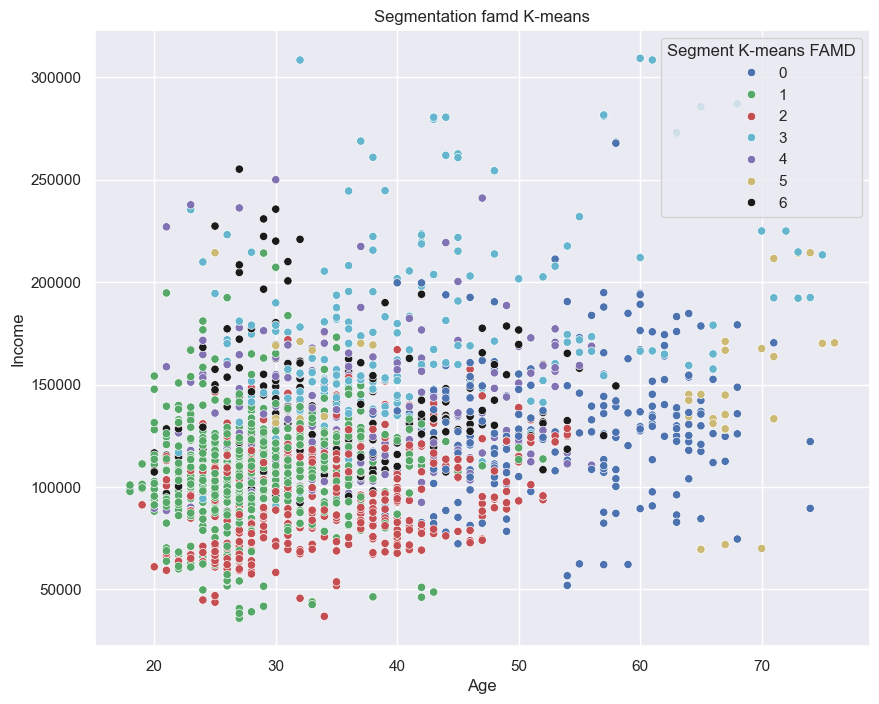

In [144]:
# We plot the results from the FAMD K-means algorithm.
# Each point in our data set is plotted with the color of the clusters it has been assigned to.
x_axis = df_seg_famd['Age']
y_axis = df_seg_famd['Income']
plt.figure(figsize = (10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_seg_famd['Segment K-means FAMD'], palette = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500'])
plt.title('Segmentation famd K-means')
plt.show()

In [151]:
import itertools

In [154]:
df_seg_famd.columns[-7:-1]

Index(['Component 1', 'Component 2', 'Component 3', 'Component 4',
       'Component 5', 'Component 6'],
      dtype='object')

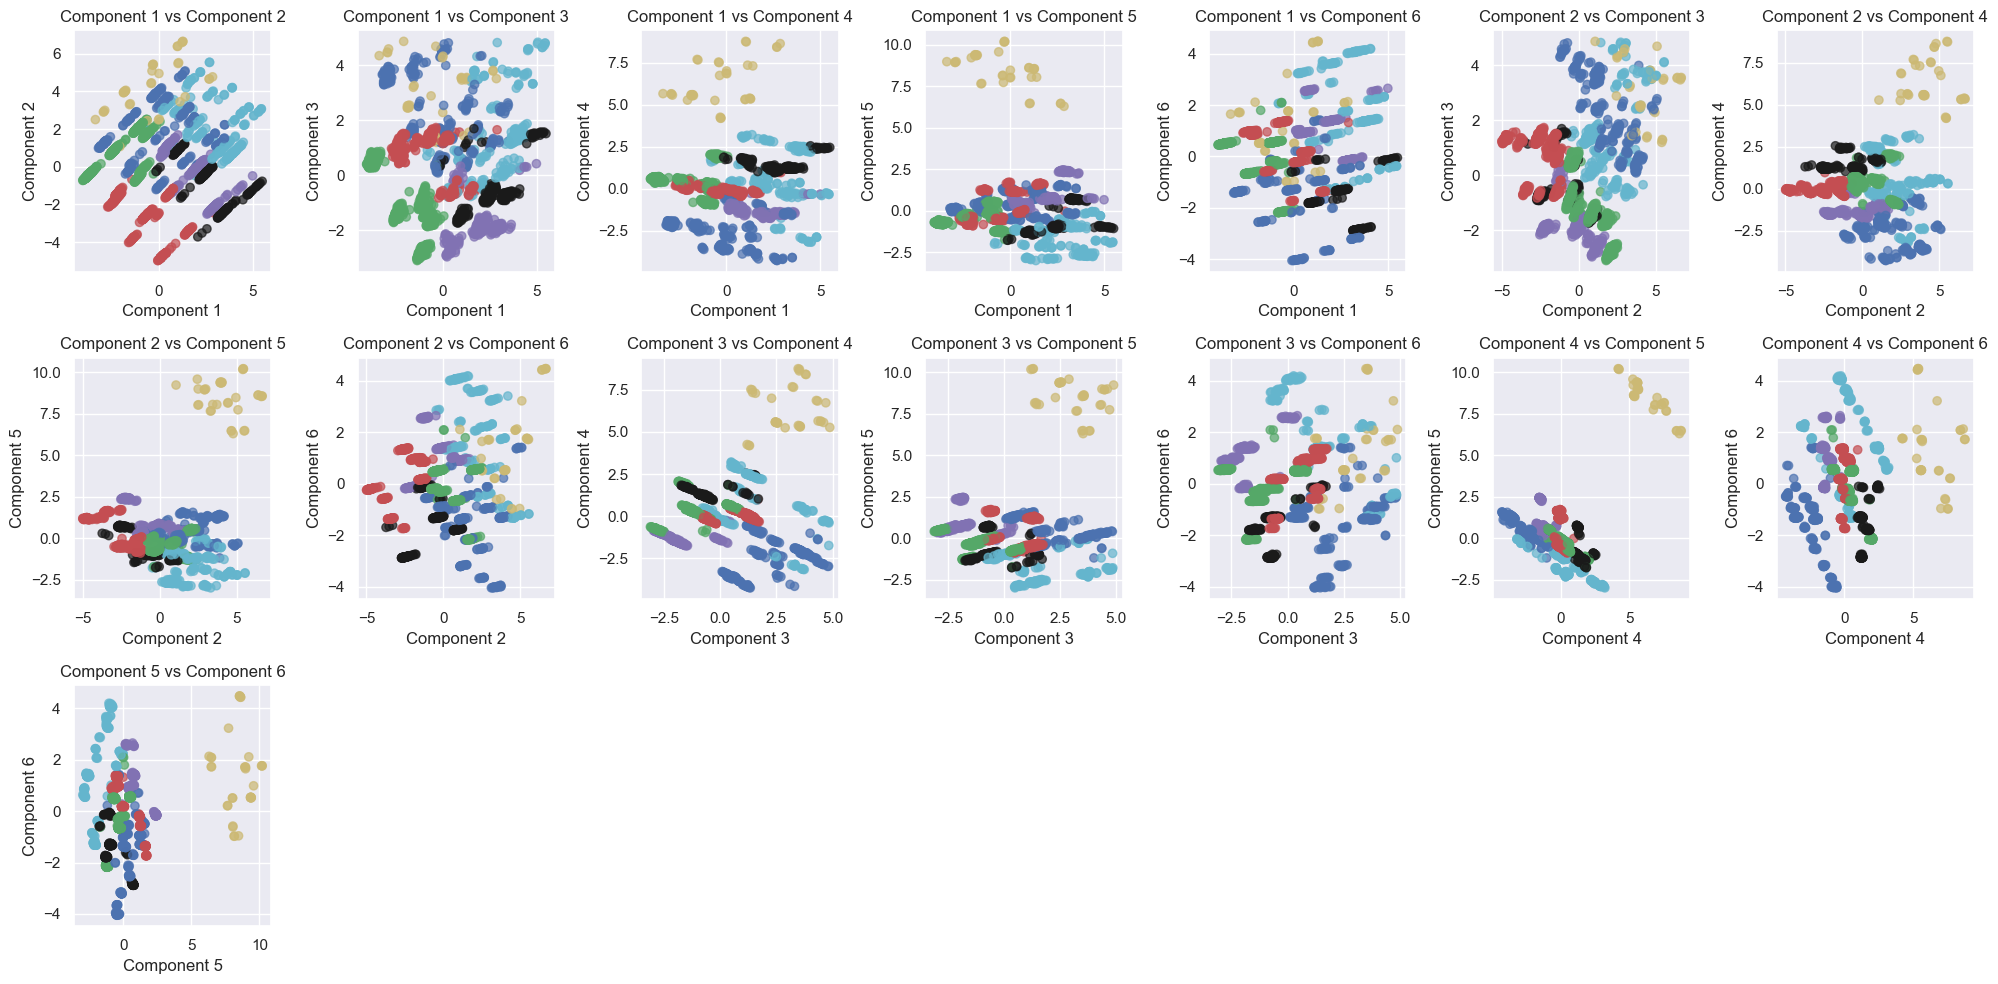

In [161]:
# 조합 구하기
combinations = list(itertools.combinations(df_seg_famd.columns[-7:-1], 2))

# plot size 계산 (예: 3행 7열 → 21 plots)
ncols = 7
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
axes = axes.flatten()

for ax, (x, y) in zip(axes, combinations):
    color_map = {
    0: 'b',
    1: 'g',
    2: 'r',
    3: 'c',
    4: 'm',
    5: 'y',
    6: 'k',
    7: '#FFA500'
}
    colors = df_seg_famd['Segment K-means FAMD'].map(color_map)  # Segment 값 → 색상
    ax.scatter(df_seg_famd[x], df_seg_famd[y],c=colors, alpha=0.7)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'{x} vs {y}')

# 빈 subplot 제거 (21개 이후의 subplot이 있으면)
for ax in axes[len(combinations):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

- 군집간 구별이 뚜렷하지 않다.

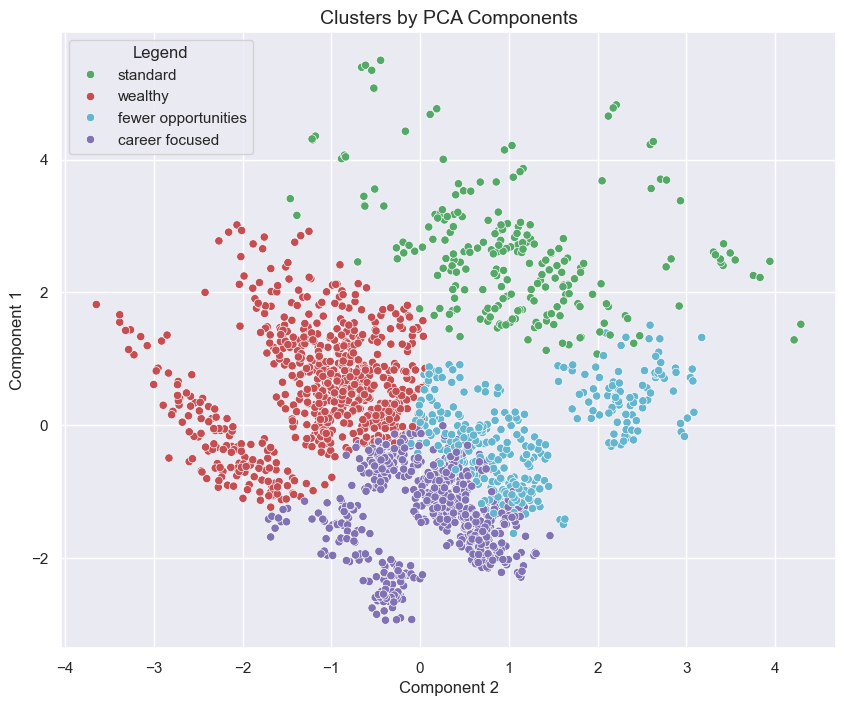

In [230]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Segment K-means PCA'])#, palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components',fontsize=14)
#plt.savefig('scaling_numeric_only.png')
plt.show()

- pca 이후 k-means clustering의 결과. 뚜렷한 cluster 구분이 이뤄진 것을 확인할 수 있다.

- 이건 범주형 변수까지 pca 적용한 clustering 결과인데 비교적 가장 뚜렷한 구분이 되어있다.

- 이론은 틀렸는데 결과가 좋게 나오니까 억울하다..